C:\Users\jhumu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sdv\lite\single_table.py:52: FutureWarning:

The 'SingleTablePreset' is deprecated. For equivalent Fast ML functionality, please use the 'GaussianCopulaSynthesizer'.

C:\Users\jhumu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sdv\lite\single_table.py:61: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

C:\Users\jhumu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sdv\single_table\base.py:144: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

C:\Users\jhumu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sdv\single_table\base.py:122: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

C:\Users\jhumu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sdv\lite\single_table.py:100: Futur

✅ Real Data Shape: (569, 31)
✅ Synthetic Data Shape: (1138, 31)

🔍 Real Sample:
    diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst

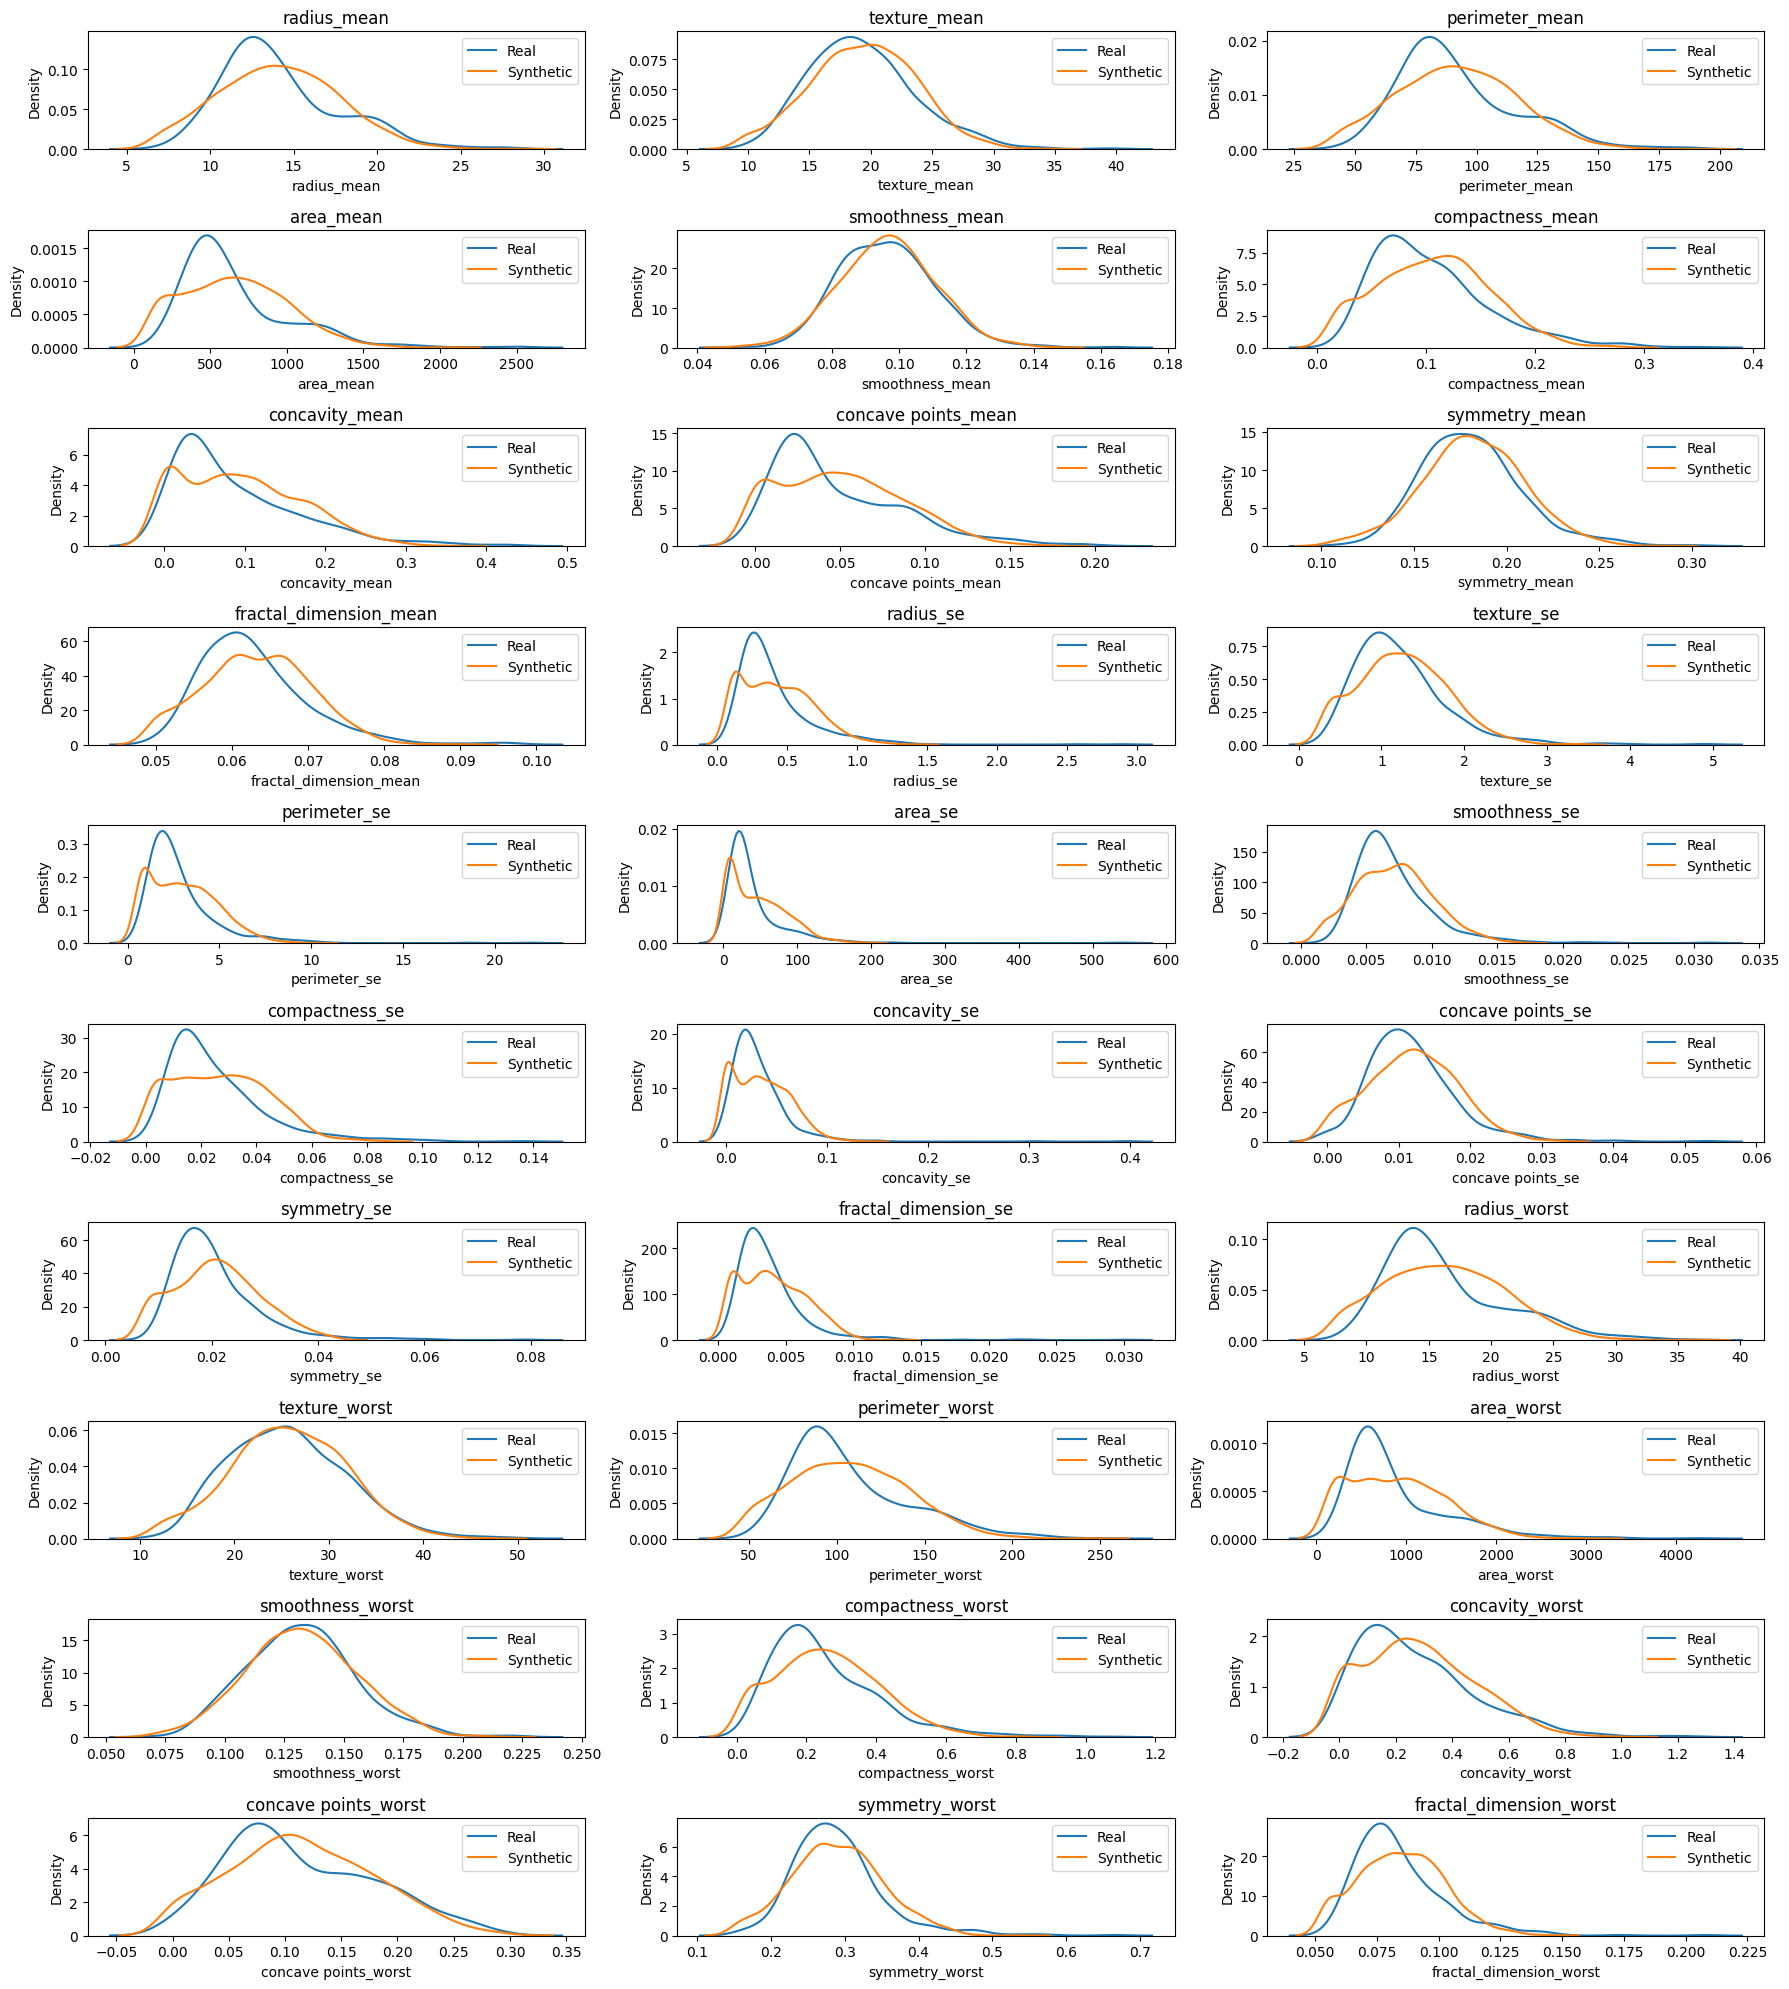


📊 Classification Report (Train on Synthetic, Test on Real):
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        71
           1       1.00      0.77      0.87        43

    accuracy                           0.91       114
   macro avg       0.94      0.88      0.90       114
weighted avg       0.92      0.91      0.91       114



C:\Users\jhumu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sdv.metadata import SingleTableMetadata
from sdv.lite import SingleTablePreset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Load Real Data ===
df = pd.read_csv("C:/Users/jhumu/Downloads/data.csv")
df.drop(columns=["Unnamed: 32", "id"], errors='ignore', inplace=True)

# Encode target
le = LabelEncoder()
df["diagnosis"] = le.fit_transform(df["diagnosis"])  # M = 1, B = 0

# === Define Metadata for SDV ===
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df)

# === Fit the FAST_ML Preset Model ===
model = SingleTablePreset(metadata=metadata, name='FAST_ML')
model.fit(df)

# === Generate Synthetic Data (2x) ===
synthetic_data = model.sample(num_rows=len(df) * 2)

# === Save Synthetic Data ===
synthetic_data.to_csv("C:/Users/jhumu/Regular Use/JupyNote/synthetic_data_sdv_v120.csv", index=False)

# === Show Real & Synthetic Info ===
print("✅ Real Data Shape:", df.shape)
print("✅ Synthetic Data Shape:", synthetic_data.shape)
print("\n🔍 Real Sample:\n", df.head())
print("\n🔍 Synthetic Sample:\n", synthetic_data.head())

# === Visualize Real vs Synthetic ===
num_cols = df.select_dtypes(include='number').columns.drop('diagnosis')
fig, axs = plt.subplots(len(num_cols) // 3, 3, figsize=(18, 20))
axs = axs.flatten()

for i, col in enumerate(num_cols[:len(axs)]):
    sns.kdeplot(df[col], label='Real', ax=axs[i])
    sns.kdeplot(synthetic_data[col], label='Synthetic', ax=axs[i])
    axs[i].set_title(col)
    axs[i].legend()

plt.tight_layout()
plt.show()

# === Train on Synthetic, Test on Real ===
X_real = df.drop('diagnosis', axis=1)
y_real = df['diagnosis']
X_synth = synthetic_data.drop('diagnosis', axis=1)
y_synth = synthetic_data['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_synth, y_synth)
y_pred = model_lr.predict(X_test)

print("\n📊 Classification Report (Train on Synthetic, Test on Real):")
print(classification_report(y_test, y_pred))
